In [278]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch

from scipy.interpolate import interp2d
from scipy.stats import beta, multivariate_normal, nct, t

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note: `get_posterior_quantiles_oracle.py` contains a clean version of this code. The reason I am keeping this notebook around is that it contains code for some visualizations that may be useful. 

**Inputs**:
- A small number of calibration data for each class $k$
- A prior distribution on the Beta distribution parameters. Eventually, we will want to estimate these using maximum likelihood (a la empirical Bayes), but until I figure out how to do that, we will use the KDE distribution fit to the "ground truth" parameters (estimated using all of ImageNet train)

**Output**
- Oracle prior for $\alpha, \beta$

# 1. Setup

## 1a. Prepare inputs

In [279]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [321]:
# Select subset of data
np.random.seed(0)

n = 20 # Number of calibration points per class k
num_classes = 1000

softmax_scores_subset = np.zeros((num_classes * n, num_classes))
labels_subset = np.zeros((num_classes * n, ), dtype=np.int32)

for k in range(num_classes):
    
    # Randomly select n instances of class k
    idx = np.argwhere(labels==k).flatten()
    selected_idx = np.random.choice(idx, replace=False, size=(n,))
    
    softmax_scores_subset[n*k:n*(k+1), :] = softmax_scores[selected_idx, :]
    labels_subset[(n*k):(n*(k+1))] = k

In [323]:
# Only select data for which k is true class
scores_subset = 1 - np.array([softmax_scores_subset[row,labels_subset[row]] for row in range(len(labels_subset))])

In [324]:
# Load KDE estimate of prior
with open('.cache/kde.pkl', 'rb') as f:
    kde = pickle.load(f)

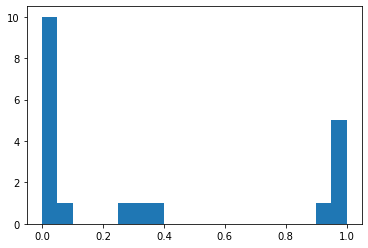

In [325]:
# Sanity check: Plot score distribution for a single class
k = 34
vals = scores_subset[labels_subset==k]
plt.hist(vals, bins=20)
plt.show()

## 1b. Hyperparameters and helper functions

In [326]:
# ===== Hyperparameters =====

num_classes = 1000

# Grid
xmin, xmax = 0, 4 # Grid bounds
ymin, ymax = 0, 4 # Grid bounds
nbins = 100 # Use 100 x 100 grid for now
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # Use 100 x 100 grid for now
positions = np.vstack([X.ravel(), Y.ravel()])

# # Threshold for truncating probability distribution
# threshold = .001 # this is over a small area 

# Number of rejection sampling samplies
num_samples = 1000

# Grid for discretizing Beta mixture
mixture_grid = np.linspace(1e-5,1-(1e-5),2000) # Exclude 0 and 1 since Beta density blows up at those points

# Specify quantile
alpha = 0.1

In [327]:
D = kde(positions) # Evaluate D on grid

In [380]:
def compute_classk_prod_f(k, a, b, n, scores_subset,logscale=False):
    '''
    Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    
    Inputs:
        k: class
        a, b: parameters of Beta(a,b)
        scores_subset: vector in which first n elements are scores for class 0, 
        second n elements are scores for class 1, and so on
    '''
    classk_scores = scores_subset[k*n:(k+1)*n]
    
    # Weirdly, some scores are exactly 0, which is a problem because the Beta 
    # density blows up at 0 for some alpha, beta values. We replace these 0 
    # values with randomly sampled values from classk_scores
    classk_scores[classk_scores == 0] = np.random.choice(classk_scores[~(classk_scores == 0)], 
                                                         size=classk_scores[classk_scores == 0].shape,
                                                         replace=True)
    
    f_ski = beta.pdf(classk_scores, a, b)
    
    if logscale:
        log_prod = np.sum(np.log(f_ski))
        return log_prod
    else:     
        prod = np.prod(f_ski)
        return prod

def compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, n_k, scores_subset):
    '''
    Applies compute_classk_prod_f to all grid points in positions. Replaces nan entries
    with 0 and normalizes the distribution 
    
    Input:
        -k: class
        -n_k: number of instances of class k
    
    Outputs:
        prob: vector of probabilities
        density: prob reshaped into a matrix
    '''

    prod_f = np.array([compute_classk_prod_f(k, positions[0,i], positions[1,i], n_k, scores_subset) 
                       for i in range(len(positions[0]))])
    prob = prod_f * D

    # Replace nan entries with 0
    prob[np.isnan(prob)] = 0

    # We can normalize this discretized distribution
    grid_area = ((xmax - xmin) / nbins) * ((ymax - ymin) / nbins)
    prob = prob / (np.sum(prob * grid_area))
    
    # Reshape probs from vector into square matrix
    density = np.reshape(prob, X.shape) 
    
    # Check if probability contains NaNs or infs
    if np.sum(np.isnan(prob)) + np.sum(np.isinf(prob)) > 0:
        print(f"WARNING: Probabilities for class {k} contains NaNs and/or inf")

    return prob, density


# def get_quantile(density, grid, alpha):
#     assert(np.sum(np.isnan(density) + np.isinf(density)) == 0)
    
# #     density /= np.sum(density) # ensure that density is normalized to sum to 1
#     grid_width = grid[1] - grid[0]
#     sums = np.cumsum(density) * grid_width
#     min_idx = np.argwhere(sums >= 1 - alpha)[0,0]
    
#     return grid[min_idx]

In [329]:
# %%time

# quantiles = np.zeros((num_classes,))

# mixture_grid = np.linspace(1e-5,1-(1e-5),1000) # Exclude 0 and 1 since Beta density blows up at those points

# for k in range(num_classes):
#     print(f"Class {k}")

#     # Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
#     prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, scores_subset)
#     weights = prob / np.sum(prob)
    
#     mixture_density = np.zeros(mixture_grid.shape)
#     for i in range(len(prob)):
# #         print(positions[0,i], positions[1,i])
#         vals = weights[i] * beta.pdf(mixture_grid, positions[0,i], positions[1,i])
#         vals[np.isnan(vals)] = 0 # Replace nan entries with 0
#         mixture_density += vals
# #         print(mixture_density)

#     # Compute quantile
#     quantile = get_quantile(mixture_density, mixture_grid, alpha)
#     print(f"Quantile: {quantile:.4f}")
#     quantiles[k] = quantile
    
# #     break

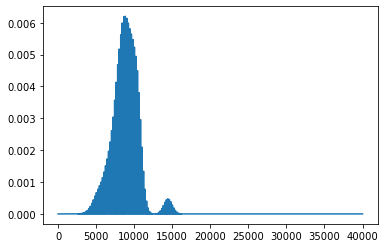

In [330]:
plt.plot(weights)

In [331]:
# Test seaborn plotting
# x = np.linspace(0,1,20)

# import pandas as pd
# import seaborn as sns
# df = pd.DataFrame({'vals': x})
# sns.relplot(x='vals', y='vals', size="vals", sizes=(20, 200), alpha=0.5, data=df)

## 2. Estimate quantiles

Let $f(x; \alpha, \beta) := \frac{1}{B(\alpha,\beta)}x^{\alpha-1}(1-x)^{\beta-1}$ denote the probability density function of $Beta(\alpha, \beta)$. Let $D(\alpha, \beta)$ denote the prior distribution of the Beta distribution parameters $\alpha$ and $\beta$. 

The distribution of an arbitrary score $s_{k,new}$ for class $k$ is a mixture of Betas:
$$p(s_{k,new}) = \int_0^{\infty} \int_0^{\infty} f(s_{k,new}; \alpha_k, \beta_k) p(\alpha_k, \beta_k | s_k, D) d\alpha_k d\beta_k$$


First, let's figure out how to sample from $p(\alpha_k, \beta_k | s_k, D)$

**Step 1**: Plot $p(\alpha_k, \beta_k | s_k, D)\propto \prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k) D(\alpha, \beta)$

### Sampling approach (6/1/22)
Sample $\alpha_k, \beta_k \sim p(\alpha_k, \beta_k | s_k, D)$. Then sample $s_{k,i} \sim \text{Beta}(\alpha_k, \beta_k)$. Repeat $n$ times

In [385]:
%%time

quantiles = np.zeros((num_classes,))

num_samples = 10000 #100000

for k in range(num_classes):
    print(f"Class {k}")

    # Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, n, scores_subset)
    normalized_prob = prob / np.sum(prob)
    
    samples = np.zeros((num_samples,))
    
    for i in range(num_samples):
        
        # 1. Sample alpha_k, beta_k
        idx = np.random.choice(np.arange(len(normalized_prob)), p=normalized_prob)
        alpha_k = positions[0,idx]
        beta_k = positions[1, idx]
#         print('alpha_k, beta_k:', alpha_k, beta_k)
        
        # 2. Sample score
        samples[i] = np.random.beta(alpha_k, beta_k)

    # Compute quantile
    quantile = np.quantile(samples, 1-alpha, interpolation='higher') # or np.ceil((1-alpha)*(n+1))/n quantile?
    
    print(f"Quantile: {quantile:.4f}")
    quantiles[k] = quantile

np.save('quantiles_060822.npy', quantiles)

Class 0
Quantile: 0.7096
Class 1
Quantile: 0.8741
Class 2
Quantile: 0.9418
Class 3
Quantile: 0.9257
Class 4
Quantile: 0.9256
Class 5
Quantile: 0.9718
Class 6
Quantile: 0.9211
Class 7
Quantile: 0.9617
Class 8
Quantile: 0.9350
Class 9
Quantile: 0.6152
Class 10
Quantile: 0.7572
Class 11
Quantile: 0.7829
Class 12
Quantile: 0.9227
Class 13
Quantile: 0.8538
Class 14
Quantile: 0.7655
Class 15
Quantile: 0.7395
Class 16
Quantile: 0.7410
Class 17
Quantile: 0.7056
Class 18
Quantile: 0.8935
Class 19
Quantile: 0.8407
Class 20
Quantile: 0.8553
Class 21
Quantile: 0.8705
Class 22
Quantile: 0.7317
Class 23
Quantile: 0.8697
Class 24
Quantile: 0.5561
Class 25
Quantile: 0.9661
Class 26
Quantile: 0.9425
Class 27
Quantile: 0.9165
Class 28
Quantile: 0.8277
Class 29
Quantile: 0.7943
Class 30
Quantile: 0.8733
Class 31
Quantile: 0.9545
Class 32
Quantile: 0.8956
Class 33
Quantile: 0.9353
Class 34
Quantile: 0.9870
Class 35
Quantile: 0.9614
Class 36
Quantile: 0.9915
Class 37
Quantile: 0.8547
Class 38
Quantile: 0.9

Quantile: 0.9373
Class 309
Quantile: 0.9151
Class 310
Quantile: 0.9666
Class 311
Quantile: 0.9611
Class 312
Quantile: 0.9217
Class 313
Quantile: 0.7629
Class 314
Quantile: 0.9120
Class 315
Quantile: 0.8826
Class 316
Quantile: 0.6587
Class 317
Quantile: 0.6943
Class 318
Quantile: 0.8605
Class 319
Quantile: 0.9241
Class 320
Quantile: 0.8799
Class 321
Quantile: 0.6954
Class 322
Quantile: 0.8111
Class 323
Quantile: 0.8113
Class 324
Quantile: 0.8200
Class 325
Quantile: 0.8899
Class 326
Quantile: 0.9686
Class 327
Quantile: 0.7716
Class 328
Quantile: 0.7992
Class 329
Quantile: 0.9716
Class 330
Quantile: 0.7056
Class 331
Quantile: 0.8475
Class 332
Quantile: 0.9230
Class 333
Quantile: 0.8574
Class 334
Quantile: 0.5833
Class 335
Quantile: 0.8100
Class 336
Quantile: 0.8246
Class 337
Quantile: 0.9175
Class 338
Quantile: 0.7502
Class 339
Quantile: 0.6522
Class 340
Quantile: 0.5989
Class 341
Quantile: 0.9658
Class 342
Quantile: 0.9054
Class 343
Quantile: 0.7767
Class 344
Quantile: 0.8235
Class 345
Q

Quantile: 0.8250
Class 613
Quantile: 0.9287
Class 614
Quantile: 0.9539
Class 615
Quantile: 0.8528
Class 616
Quantile: 0.9622
Class 617
Quantile: 0.9604
Class 618
Quantile: 0.9989
Class 619
Quantile: 0.9804
Class 620
Quantile: 0.9879
Class 621
Quantile: 0.9560
Class 622
Quantile: 0.8982
Class 623
Quantile: 0.9957
Class 624
Quantile: 0.9919
Class 625
Quantile: 0.8968
Class 626
Quantile: 0.9886
Class 627
Quantile: 0.8700
Class 628
Quantile: 0.8242
Class 629
Quantile: 0.9621
Class 630
Quantile: 0.9359
Class 631
Quantile: 0.9966
Class 632
Quantile: 0.9954
Class 633
Quantile: 0.9903
Class 634
Quantile: 0.9839
Class 635
Quantile: 0.9330
Class 636
Quantile: 0.9811
Class 637
Quantile: 0.9834
Class 638
Quantile: 0.9956
Class 639
Quantile: 0.9936
Class 640
Quantile: 0.5617
Class 641
Quantile: 0.9771
Class 642
Quantile: 0.5980
Class 643
Quantile: 0.9934
Class 644
Quantile: 0.9911
Class 645
Quantile: 0.6834
Class 646
Quantile: 0.9415
Class 647
Quantile: 0.9875
Class 648
Quantile: 0.9897
Class 649
Q

Quantile: 0.9585
Class 935
Quantile: 0.9880
Class 936
Quantile: 0.8020
Class 937
Quantile: 0.9471
Class 938
Quantile: 0.7862
Class 939
Quantile: 0.9529
Class 940
Quantile: 0.9706
Class 941
Quantile: 0.7682
Class 942
Quantile: 0.9240
Class 943
Quantile: 0.9908
Class 944
Quantile: 0.9113
Class 945
Quantile: 0.9583
Class 946
Quantile: 0.6738
Class 947
Quantile: 0.9948
Class 948
Quantile: 0.9704
Class 949
Quantile: 0.9052
Class 950
Quantile: 0.9586
Class 951
Quantile: 0.9609
Class 952
Quantile: 0.8806
Class 953
Quantile: 0.9594
Class 954
Quantile: 0.8500
Class 955
Quantile: 0.5802
Class 956
Quantile: 0.8619
Class 957
Quantile: 0.6421
Class 958
Quantile: 0.8725
Class 959
Quantile: 0.8476
Class 960
Quantile: 0.9681
Class 961
Quantile: 0.9036
Class 962
Quantile: 0.9384
Class 963
Quantile: 0.9086
Class 964
Quantile: 0.9753
Class 965
Quantile: 0.8599
Class 966
Quantile: 0.9988
Class 967
Quantile: 0.9785
Class 968
Quantile: 0.9948
Class 969
Quantile: 0.9382
Class 970
Quantile: 0.9752
Class 971
Q

In [383]:
# k = 137
# plt.hist(scores_subset[labels_subset == k])

## Debugging (pt. 1)

In [54]:
# # Visualize D(alpha, beta)
# max_D = np.max(D)
# for i in range(positions.shape[1]):
#     weight = D[i] / max_D
#     plt.scatter(positions[0,i], positions[1,i], alpha=weight,  color='blue')

# plt.xlabel('$\\alpha$')
# plt.ylabel('$\\beta$')
# plt.title('$D(\\alpha, \\beta)$')
# plt.show()

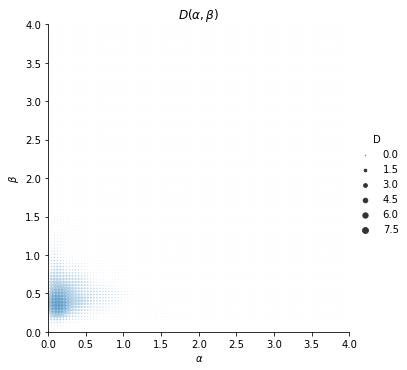

In [168]:
# Visualize D(alpha, beta)
df = pd.DataFrame({'alpha': positions[0,:], 'beta': positions[1,:], 'D': D})
sns.relplot(x='alpha', y='beta', size='D', sizes=(0.1, 40), alpha=0.3, data=df)

plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('$D(\\alpha, \\beta)$')
plt.show()

In [172]:
# Choose class
k = 3

prob, prob_matrix = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, scores_subset)

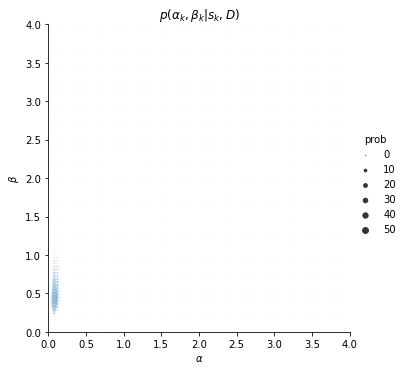

In [173]:
# Visualize p(\alpha_k, \beta_k | s_k, D)
df = pd.DataFrame({'alpha': positions[0,:], 'beta': positions[1,:], 'prob': prob})
sns.relplot(x='alpha', y='beta', size='prob', sizes=(0.1, 40), alpha=0.3, data=df)

plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('$p(\\alpha_k, \\beta_k | s_k, D)$')
plt.show()

Text(0.5, 1.0, 'Density of Beta(0.1, 0.5)')

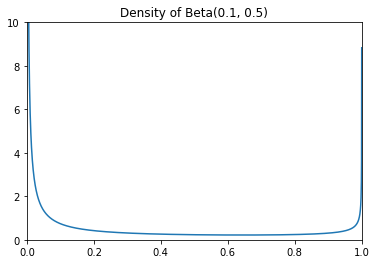

In [174]:
# Visualize Beta densities
a = 0.1 # alpha
b = 0.5 # beta

grid = np.linspace(1e-4,1-1e-4,2000)
beta_density = beta.pdf(grid, a, b)
plt.plot(grid, beta_density)
# plt.ylim(bottom=0)
plt.ylim(0,10)
plt.xlim(0,1)
plt.title(f"Density of Beta({a}, {b})")

In [175]:
alpha = 0.1
get_quantile(beta_density, grid, alpha)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [178]:
grid_width = grid[1] - grid[0]
density = beta_density
sums = np.cumsum(density) * grid_width
sums  

array([0.17585601, 0.21091763, 0.23124188, ..., 0.769693  , 0.77149702,
       0.7759145 ])

In [176]:
# Inverse cdf
beta.ppf(1-alpha, a, b)

0.7327778086894582

In [123]:
alpha = 0.1
density = beta_density
grid_width = grid[1] - grid[0]
sums = np.cumsum(density) * grid_width
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [122]:
alpha = 0.1
density = beta_density
density /= np.sum(density) # ensure that density is normalized to sum to 1
sums = np.cumsum(density)
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]

# return grid[min_idx]
sums
grid[min_idx]

0.9999

## Debugging (pt. 2)

Compare discretized quantile estimate to ppf quantile estimate for a Beta distribution

Discretized quantile estimate: 1e-10
ppf quantile estimate: 0.7327778086894582


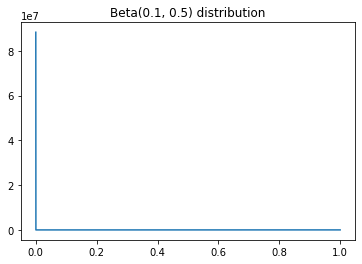

In [265]:
a = 0.1
b = 0.5

# a = 2
# b = 2

alpha = 0.1

## 1.  Discretized
eps = 1e-10 # To avoid evaluating Beta at 0 or 1, where density blows up to infinity for some alpha, beta combos

# Option A: Basic grid
grid = np.linspace(eps, 1-eps, 10000000)

# Option B: Grid with higher density at tails
# grid1 = np.linspace(eps, 0.1, 10000)
# grid2 = np.linspace(0.1, 0.9, 2000)
# grid3 = 1 - grid1
# grid = np.concatenate((grid1, grid2, grid3))
# plt.scatter(grid, np.ones(grid.shape), alpha=0.1) # Visualize grid

disc_beta = beta.pdf(grid, a , b)
grid_width = grid[1] - grid[0]
sums = np.cumsum(disc_beta) * grid_width
# grid_width = grid[1:] - grid[:-1]
# # cumsum = np.cumsum(disc_beta)
# sums = (disc_beta[:1] + disc_beta[1:]) / 2  * grid_width # Midpoint integral
min_idx = np.argwhere(sums >= 1 - alpha)[0,0]
quantile_est1 = grid[min_idx]
print("Discretized quantile estimate:", quantile_est1)

## 2. Using .ppf
quantile_est2 = beta.ppf(1-alpha, a, b)
print("ppf quantile estimate:", quantile_est2)

# Visualize the beta distribution
plt.plot(grid, disc_beta)
# plt.plot(grid, sums)
plt.title(f'Beta({a}, {b}) distribution')
# plt.ylim(bottom = 0)
# plt.xlim(0,1)
plt.show()

In [266]:
disc_beta

array([8.83151390e+07, 1.76053422e+05, 9.43871301e+04, ...,
       1.97429329e+02, 2.79137469e+02, 8.83151353e+03])

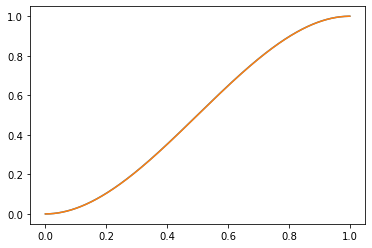

In [254]:
plt.plot(grid, sums)
plt.plot(grid, beta.cdf(grid, a, b))

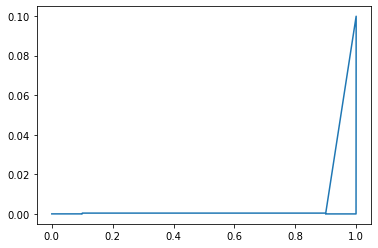

In [245]:
plt.plot(grid[1:], grid_width)
plt.show()